In [7]:
import pandas as pd 
import numpy as np
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
import pymongo
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

In [8]:
#export the data
df=pd.read_excel('Sales.xls')
df.head(20)

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fred.stlouisfed.org/help-faq,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
5,NaN,NaN
6,S4248SM144NCEN,"Merchant Wholesalers, Except Manufacturers' Sa..."
7,NaN,NaN
8,Frequency: Monthly,NaN
9,observation_date,S4248SM144NCEN


In [9]:
#cleaning the data

In [16]:
df1=df.iloc[10:]
df1['FRED Graph Observations'] = pd.to_datetime(df1['FRED Graph Observations'])
df1['Unnamed: 1'] = df1['Unnamed: 1'].astype(int)
df1=df1.set_index(df1['FRED Graph Observations'])
df1.index.freq = 'MS'

In [18]:
del df1['FRED Graph Observations']

In [19]:
#renaming columns
df1.rename(columns={'Unnamed: 1':'sales'},inplace=True)

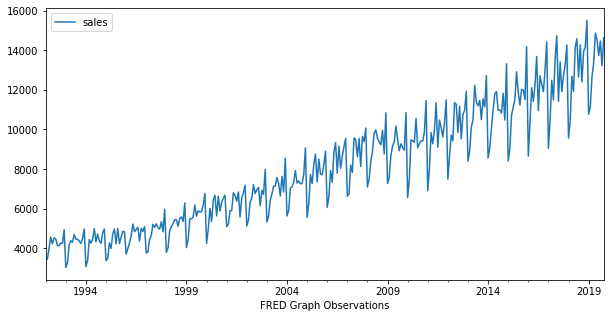

In [20]:
#plot the data
df1.plot(figsize=(10,5))

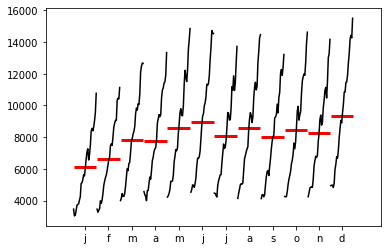

In [24]:
month_plot(df1['sales']);

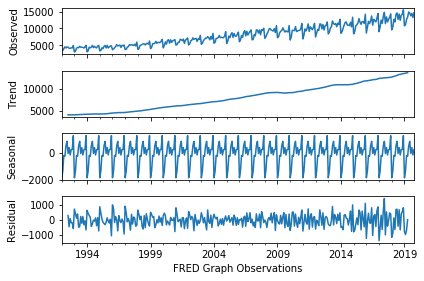

In [25]:
check_trend_seasonality=seasonal_decompose(df1,model='add').plot();

In [26]:
#use ML to check which arima model best works
auto_arima(df1['sales'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  334
Model:             SARIMAX(1, 1, 3)x(1, 0, 2, 12)   Log Likelihood               -2449.699
Date:                            Thu, 16 Jan 2020   AIC                           4917.399
Time:                                    10:45:51   BIC                           4951.672
Sample:                                         0   HQIC                          4931.065
                                            - 334                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7264      1.498      1.152      0.249      -1.210       4.663
ar.L1         -1.0000      0.042    -23.811      0.000      -1.082      -0.918
ma.L1         -0.0637      0.106     -0.600      0.549      -0.272       0.144
ma.L2         -0.7767      0.114     -6.822      0.000      -1.000      -0.554
ma.L3          0.2870      0.060      4.748      0.000       0.169       0.405
ar.S.L12       0.9912      0.007    148.612      0.000       0.978       1.004
ma.S.L12      -0.2197      0.054     -4.068      0.000      -0.325      -0.114
ma.S.L24      -0.3490      0.050     -6.921      0.000      -0.448      -0.250
sigma2      1.069e+05   8.62e-06   1.24e+10      0.000    1.07e+05    1.07e+05
===================================================================================
Ljung-Box (Q):                      438.99   Jarque-Bera (JB):                26.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+26. Standard errors may be unstable.
"""

In [31]:
#split the data into train and test data
train = df1.iloc[:322]
test = df1.iloc[322:]

In [37]:
#predict values to compare with the test set to eval model
model_train = SARIMAX(train['sales'],order=(1,1,3),seasonal_order=(1,0,2,12)).fit()
model_predict=model_train.predict(len(train),len(train)+len(test)-1).rename('predict')

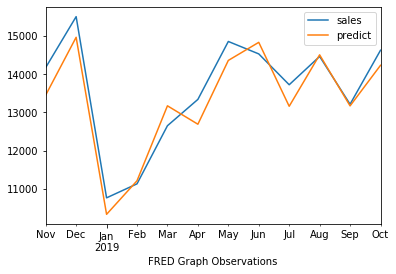

In [39]:
test.plot(legend=True)
model_predict.plot(legend=True)

In [51]:
#evaluate error for quantitive analysis
rmse_test_predict=round(rmse(test['sales'],model_predict),2)
test_mean=test['sales'].mean()
round(rmse_test_predict/test_mean * 100,2)
# confidence level almost at 97%

3.36

In [63]:
#forecast until 2020-10-01
forecast_model = SARIMAX(df1['sales'],order=(1,1,3),seasonal_order=(1,0,2,12)).fit()
final_model=forecast_model.predict(len(df1),len(df1)+11).rename('forecast')

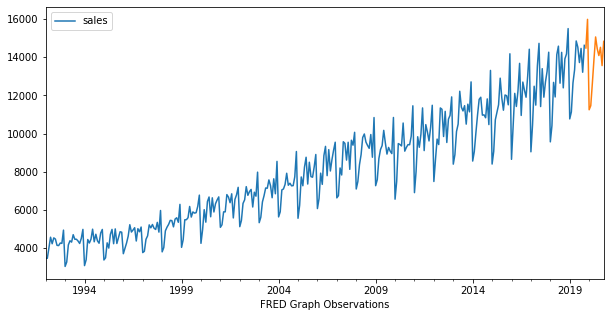

In [61]:
df1.plot(figsize=(10,5))
final_model.plot()

In [64]:
#data numbers
final_model

2019-11-01    14487.956287
2019-12-01    15988.313928
2020-01-01    11247.221029
2020-02-01    11460.053544
2020-03-01    12651.435616
2020-04-01    13908.782119
2020-05-01    15065.103231
2020-06-01    14449.077114
2020-07-01    14091.066819
2020-08-01    14521.868728
2020-09-01    13562.664797
2020-10-01    14834.096428
Freq: MS, Name: forecast, dtype: float64